In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import h5py
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import G2Net2022Dataset
from tqdm.notebook import tqdm

In [3]:
def column_norm(x):
    xn  = x - np.mean(x, axis=1, keepdims=True) # remove mean
    xn /= np.sqrt(np.sum(xn**2, axis=1, keepdims=True)) # normalize
    return xn.sum(2)


def find_similar_column(col0, xn1):
    ''' calculates cosine similarity between the normalized reference column col0 and all columns
        in the column-normalized sample xn1 '''
    return np.array([ [ np.dot(col0, col1) for col1 in img.T ] for img in xn1 ])

In [4]:
train = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/train_labels.csv')
test = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv')
train = train.loc[train['target'] != -1]

In [16]:
ds = G2Net2022Dataset(
    test.loc[test.id == '65e192431'], 
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'), 
    # train,
    # data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/train'), 
    # match_time=True,
    # spec_diff=True,
    resize_factor=8, 
    transforms=None,
    normalize='local')

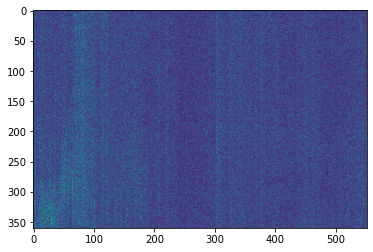

In [17]:
plt.imshow(ds[0][0][:, :, 0])

In [38]:
for idx, (xn1, _) in enumerate(tqdm(ds)):
    xn1 = column_norm(xn1)
    cs = find_similar_column(xn0[:, 256], xn1)
    csm = cs.max()
    if csm > 0.9:
        print(idx, csm, cs.argmax())

  0%|          | 0/7975 [00:00<?, ?it/s]